In [1]:
%pylab inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as utils

from torchvision import datasets
from torchvision.transforms import ToTensor, Grayscale

# from tqdm import trange, tqdm
from functools import partial
from tqdm import tqdm, trange
tqdm = partial(tqdm, position=0, leave=True)
trange = partial(trange, position=0, leave=True)


figsize(10,10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Mon Jun 27 09:40:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
DEVICE='cuda:0'

In [5]:
BATCH=256

In [6]:
train_data = datasets.MNIST(
	root='data',
	train=True,
	transform=transforms.Compose([
		ToTensor(),
		transforms.Normalize((0.5), (0.5))
	]),
	download=True,
);

trainloader = torch.utils.data.DataLoader(
	train_data,
	batch_size=BATCH,
	num_workers=12,
	shuffle=True
)
print(len(trainloader))

235


torch.Size([1, 28, 28])


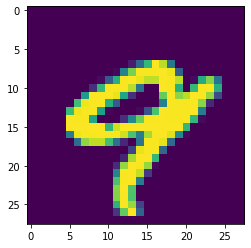

In [7]:
for i, data in enumerate(trainloader):
	if i == 10:
		print(data[0][0].shape)
		imshow(data[0][0].reshape(28,28).numpy())

In [8]:
GEN_INP_DIM = 15

In [9]:
lin_out = 32 * 10 * 10

class G(nn.Module):
	def __init__(self):
		super(G, self).__init__()
	
		self.lin = nn.Sequential(
			nn.Linear(GEN_INP_DIM, lin_out),
			nn.BatchNorm1d(lin_out),
			nn.ELU(),
		)

		self.deconvs = nn.Sequential(
			nn.ConvTranspose2d(32, 32, 7),
			nn.BatchNorm2d(32),
			nn.ELU(),

			nn.ConvTranspose2d(32, 1, 13),
			nn.Tanh()
		)

	def forward(self, x):
		x = self.lin(x)
		x = x.reshape(BATCH, 32, 10, 10)
		x = self.deconvs(x)

		return x

noise shape: torch.Size([256, 15])
out shape: torch.Size([256, 1, 28, 28])
out 0 shape: torch.Size([1, 28, 28])


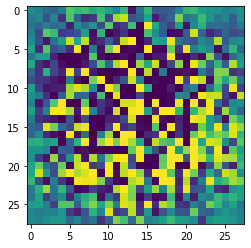

In [10]:
t_generator = G().to(DEVICE)

t_noise = torch.randn(BATCH, GEN_INP_DIM).to(DEVICE)
print('noise shape:', t_noise.shape)

t_out = t_generator(t_noise)

print('out shape:', t_out.shape)
print('out 0 shape:', t_out[0].shape)

imshow(t_out[0].reshape(t_out.shape[2], t_out.shape[3]).cpu().detach())

In [11]:
class D(nn.Module):
	def __init__(self):
		super(D, self).__init__()

		self.convs = nn.Sequential(
			nn.Conv2d(1, 32, 5),
			nn.BatchNorm2d(32),
			nn.ELU(),

			nn.Conv2d(32, 32, 5),
			nn.BatchNorm2d(32),
			nn.ELU(),
		)

		self.classifier = nn.Sequential(nn.Linear(32 * 20 * 20, 1), nn.Sigmoid())

	def forward(self, x):
		x = self.convs(x)
		x = x.reshape(x.shape[0], -1)
		x = self.classifier(x)

		return x

In [12]:
generator = G().to(DEVICE)
discriminator = D().to(DEVICE)

In [13]:
bce = nn.BCELoss().to(DEVICE)

g_optim = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999)) # 3e-4
d_optim = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999)) # 1e-5

EPOCHS = 10

d_losses = []
g_losses = []

In [14]:
def get_noise():
  n = torch.randn(BATCH, GEN_INP_DIM).to(DEVICE)
  return n

In [15]:
def test_render(g):
  n1 = get_noise()
  out = g(n1)
  return out[0].reshape(out.shape[2], out.shape[3]).cpu().detach()

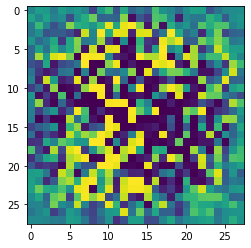

In [16]:
imshow(test_render(generator))

0it [00:00, ?it/s]

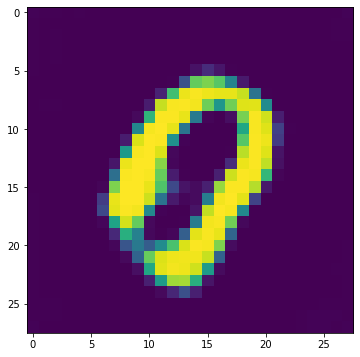

4it [00:00,  7.64it/s]


 EPOCH 0 iter 0 
 g_loss 5.023593902587891 
 d_loss 0.07553942501544952 



49it [00:02, 26.46it/s]

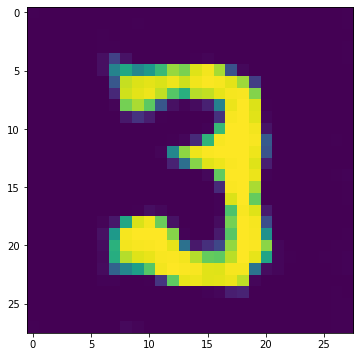

55it [00:02, 18.40it/s]


 EPOCH 0 iter 50 
 g_loss 12.440643310546875 
 d_loss 0.5627427697181702 



100it [00:04, 26.82it/s]

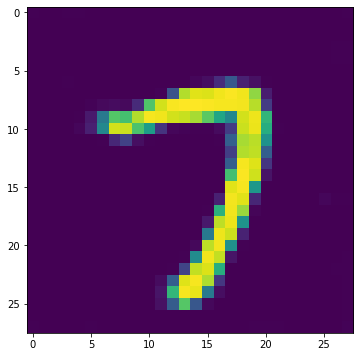

106it [00:04, 21.02it/s]


 EPOCH 0 iter 100 
 g_loss 4.663723945617676 
 d_loss 0.35659563541412354 



148it [00:06, 26.71it/s]

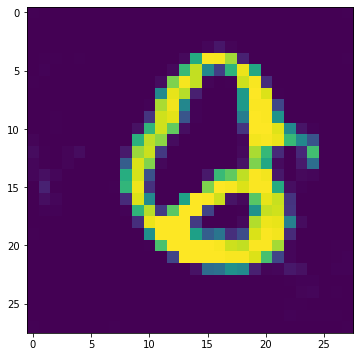

154it [00:06, 21.13it/s]


 EPOCH 0 iter 150 
 g_loss 4.927613258361816 
 d_loss 0.09100887179374695 



199it [00:08, 27.13it/s]

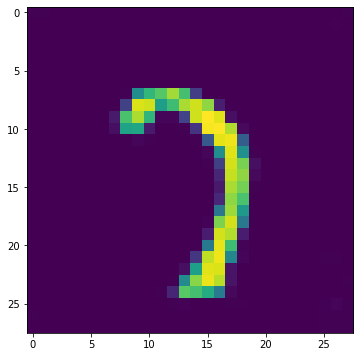

205it [00:08, 20.97it/s]


 EPOCH 0 iter 200 
 g_loss 5.400094985961914 
 d_loss 0.2106533795595169 



235it [00:10, 23.28it/s]
0it [00:00, ?it/s]

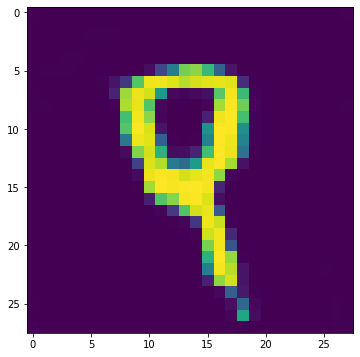

4it [00:00,  7.19it/s]


 EPOCH 1 iter 235 
 g_loss 4.182936191558838 
 d_loss 0.07292790710926056 



49it [00:02, 26.71it/s]

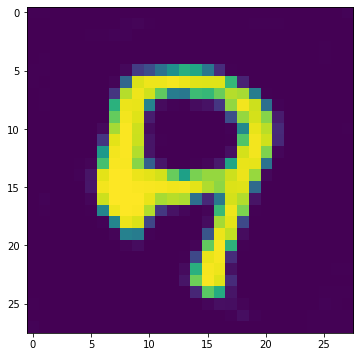

55it [00:02, 20.70it/s]


 EPOCH 1 iter 285 
 g_loss 4.4660139083862305 
 d_loss 0.045054249465465546 



100it [00:04, 26.50it/s]

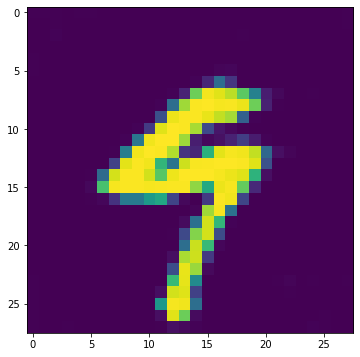

106it [00:04, 20.98it/s]


 EPOCH 1 iter 335 
 g_loss 6.07061767578125 
 d_loss 1.4252026081085205 



148it [00:06, 26.59it/s]

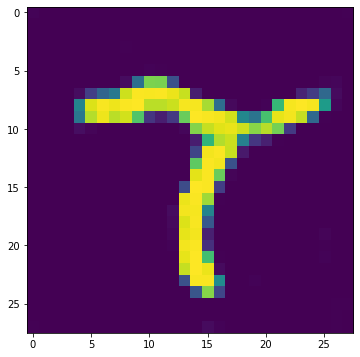

154it [00:06, 21.15it/s]


 EPOCH 1 iter 385 
 g_loss 5.389264106750488 
 d_loss 0.3920106887817383 



199it [00:08, 26.86it/s]

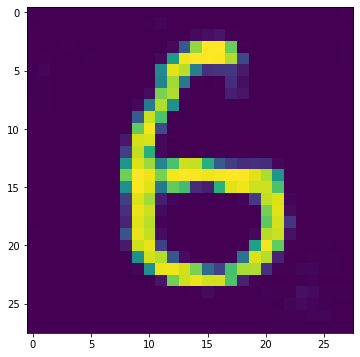

205it [00:08, 21.00it/s]


 EPOCH 1 iter 435 
 g_loss 4.451839447021484 
 d_loss 0.2051098346710205 



235it [00:10, 23.30it/s]
0it [00:00, ?it/s]

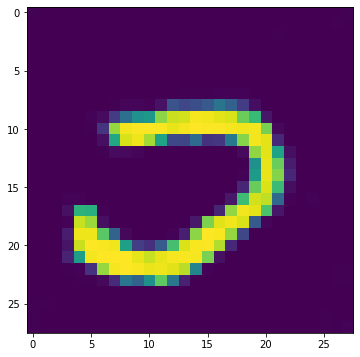

4it [00:00,  8.81it/s]


 EPOCH 2 iter 470 
 g_loss 4.515154838562012 
 d_loss 0.10029233992099762 



49it [00:02, 26.78it/s]

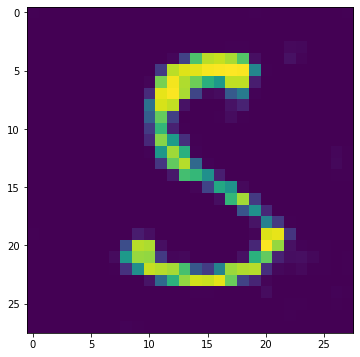

55it [00:02, 21.18it/s]


 EPOCH 2 iter 520 
 g_loss 7.916578769683838 
 d_loss 0.4262808561325073 



100it [00:04, 26.89it/s]

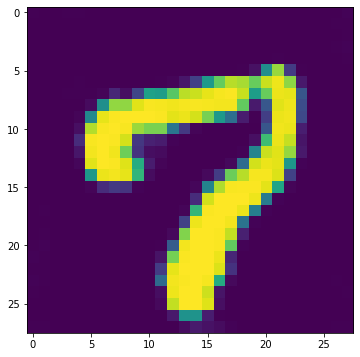

106it [00:04, 21.13it/s]


 EPOCH 2 iter 570 
 g_loss 5.749026298522949 
 d_loss 0.05084262788295746 



148it [00:06, 26.43it/s]

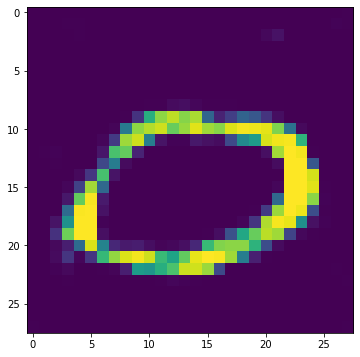

154it [00:06, 21.25it/s]


 EPOCH 2 iter 620 
 g_loss 5.237368583679199 
 d_loss 0.3072900176048279 



199it [00:08, 23.54it/s]

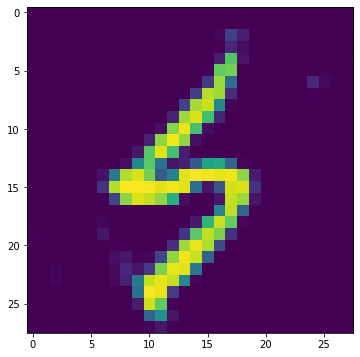

205it [00:08, 19.90it/s]


 EPOCH 2 iter 670 
 g_loss 4.110407829284668 
 d_loss 0.12647782266139984 



235it [00:10, 23.06it/s]
0it [00:00, ?it/s]

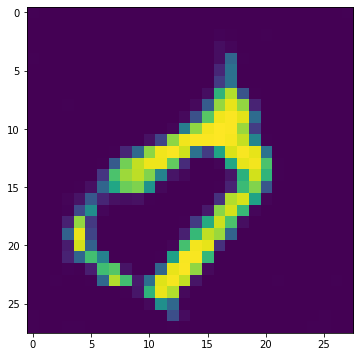

4it [00:01,  4.45it/s]


 EPOCH 3 iter 705 
 g_loss 12.408931732177734 
 d_loss 1.304735541343689 



49it [00:02, 26.15it/s]

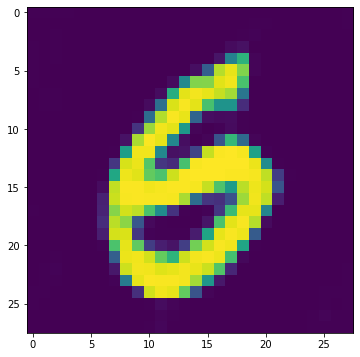

55it [00:03, 20.96it/s]


 EPOCH 3 iter 755 
 g_loss 4.005485534667969 
 d_loss 0.12421956658363342 



100it [00:04, 25.84it/s]

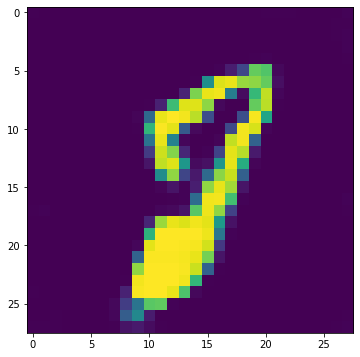

106it [00:05, 20.85it/s]


 EPOCH 3 iter 805 
 g_loss 5.881404876708984 
 d_loss 0.06455562263727188 



148it [00:06, 26.79it/s]

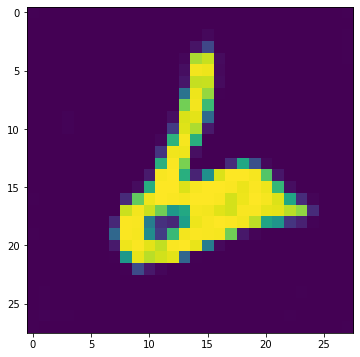

154it [00:07, 21.13it/s]


 EPOCH 3 iter 855 
 g_loss 5.260692596435547 
 d_loss 0.13540661334991455 



199it [00:08, 27.00it/s]

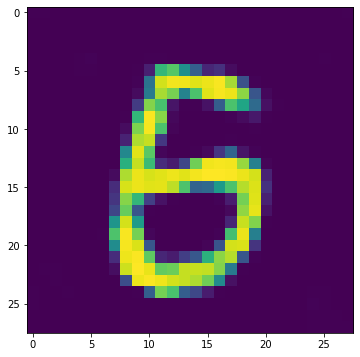

205it [00:09, 21.30it/s]


 EPOCH 3 iter 905 
 g_loss 4.61024284362793 
 d_loss 0.2978368401527405 



235it [00:10, 22.32it/s]
0it [00:00, ?it/s]

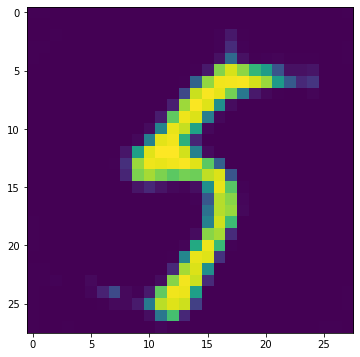

4it [00:00,  8.06it/s]


 EPOCH 4 iter 940 
 g_loss 4.522645950317383 
 d_loss 0.15571099519729614 



49it [00:02, 26.35it/s]

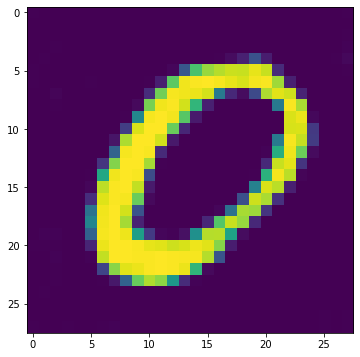

55it [00:02, 20.79it/s]


 EPOCH 4 iter 990 
 g_loss 7.623591423034668 
 d_loss 0.08671942353248596 



100it [00:04, 26.38it/s]

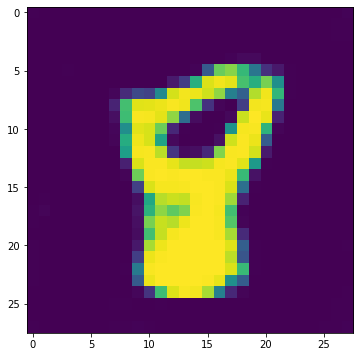

106it [00:04, 20.79it/s]


 EPOCH 4 iter 1040 
 g_loss 4.9282636642456055 
 d_loss 0.17922654747962952 



148it [00:06, 26.45it/s]

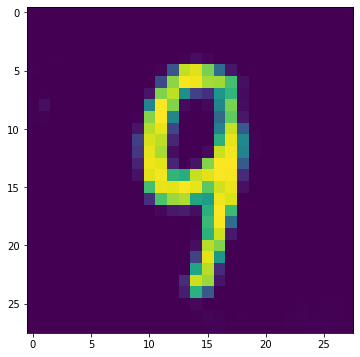

154it [00:06, 20.57it/s]


 EPOCH 4 iter 1090 
 g_loss 4.316699028015137 
 d_loss 0.19969096779823303 



199it [00:08, 26.25it/s]

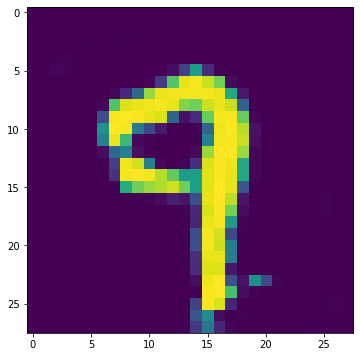

205it [00:08, 21.02it/s]


 EPOCH 4 iter 1140 
 g_loss 4.474740982055664 
 d_loss 0.10399410128593445 



235it [00:10, 23.35it/s]
0it [00:00, ?it/s]

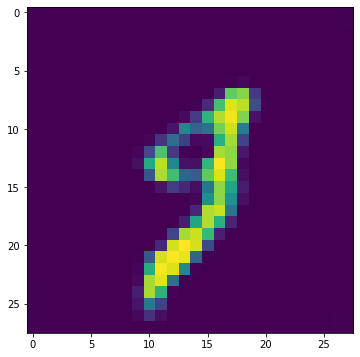

4it [00:00,  8.63it/s]


 EPOCH 5 iter 1175 
 g_loss 10.743950843811035 
 d_loss 0.8337119221687317 



49it [00:02, 26.45it/s]

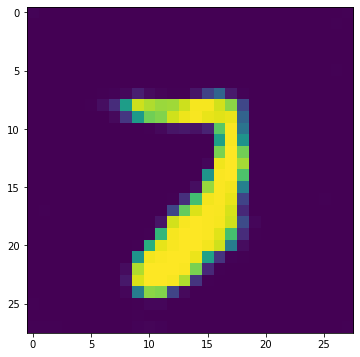

55it [00:02, 20.81it/s]


 EPOCH 5 iter 1225 
 g_loss 4.665840148925781 
 d_loss 0.14687806367874146 



100it [00:04, 26.05it/s]

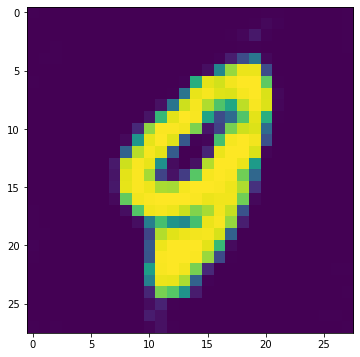

106it [00:04, 20.89it/s]


 EPOCH 5 iter 1275 
 g_loss 5.24869441986084 
 d_loss 0.11954477429389954 



148it [00:06, 26.33it/s]

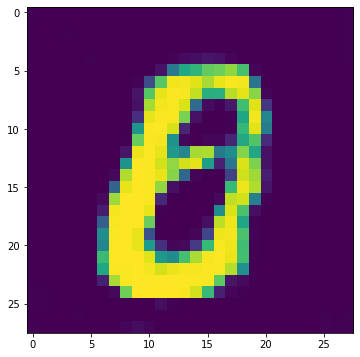

154it [00:06, 20.52it/s]


 EPOCH 5 iter 1325 
 g_loss 5.8653764724731445 
 d_loss 0.0963863730430603 



199it [00:08, 26.09it/s]

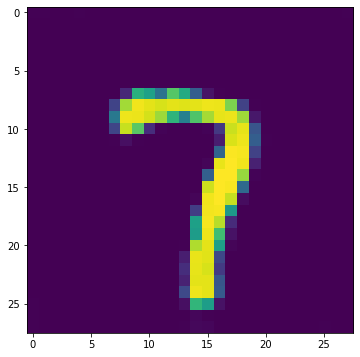

205it [00:08, 17.79it/s]


 EPOCH 5 iter 1375 
 g_loss 5.437959671020508 
 d_loss 0.06746018677949905 



235it [00:10, 23.17it/s]
0it [00:00, ?it/s]

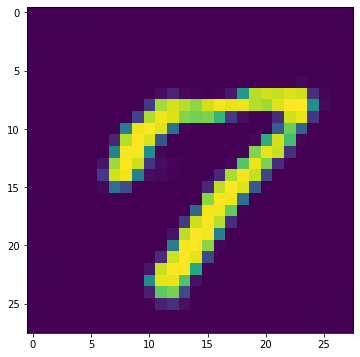

4it [00:00,  8.13it/s]


 EPOCH 6 iter 1410 
 g_loss 6.067493915557861 
 d_loss 0.43185535073280334 



49it [00:02, 25.99it/s]

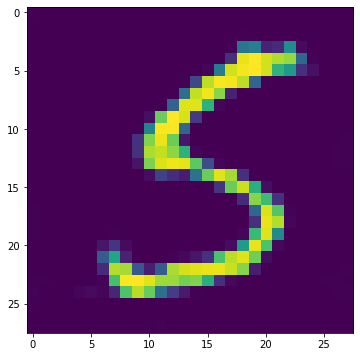

55it [00:02, 20.45it/s]


 EPOCH 6 iter 1460 
 g_loss 4.431003570556641 
 d_loss 0.1252748966217041 



100it [00:04, 26.68it/s]

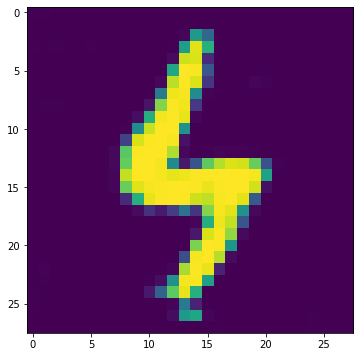

106it [00:04, 20.97it/s]


 EPOCH 6 iter 1510 
 g_loss 9.489961624145508 
 d_loss 0.3993740677833557 



148it [00:06, 26.65it/s]

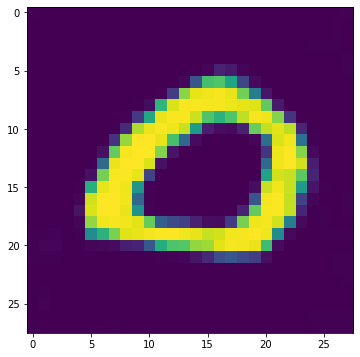

154it [00:06, 20.67it/s]


 EPOCH 6 iter 1560 
 g_loss 5.213574409484863 
 d_loss 0.11816049367189407 



199it [00:08, 26.57it/s]

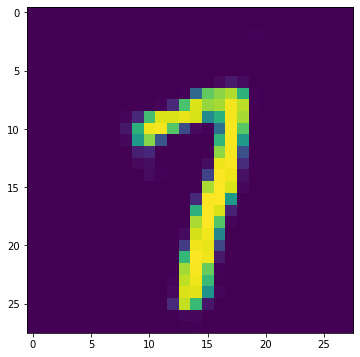

205it [00:08, 21.10it/s]


 EPOCH 6 iter 1610 
 g_loss 4.752449989318848 
 d_loss 0.07742549479007721 



235it [00:10, 23.42it/s]
0it [00:00, ?it/s]

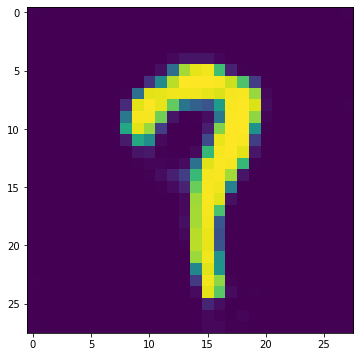

4it [00:00,  8.52it/s]


 EPOCH 7 iter 1645 
 g_loss 4.711113929748535 
 d_loss 0.12025614827871323 



49it [00:02, 26.76it/s]

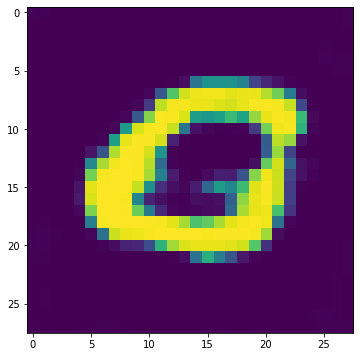

55it [00:02, 20.97it/s]


 EPOCH 7 iter 1695 
 g_loss 5.028851509094238 
 d_loss 0.1042683869600296 



100it [00:04, 26.82it/s]

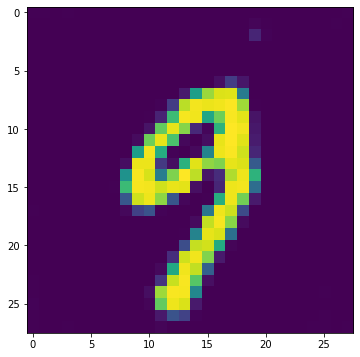

106it [00:04, 21.28it/s]


 EPOCH 7 iter 1745 
 g_loss 4.628946781158447 
 d_loss 0.11260678619146347 



148it [00:06, 26.60it/s]

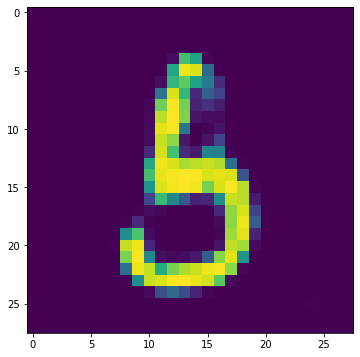

154it [00:06, 20.92it/s]


 EPOCH 7 iter 1795 
 g_loss 4.816141128540039 
 d_loss 0.0683121383190155 



199it [00:08, 26.36it/s]

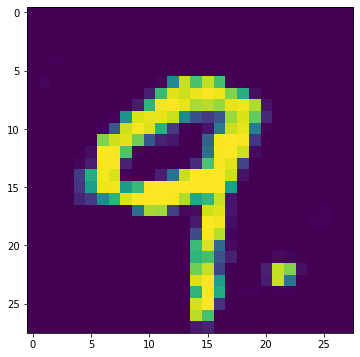

205it [00:08, 20.62it/s]


 EPOCH 7 iter 1845 
 g_loss 5.041835308074951 
 d_loss 0.12144621461629868 



235it [00:09, 23.59it/s]
0it [00:00, ?it/s]

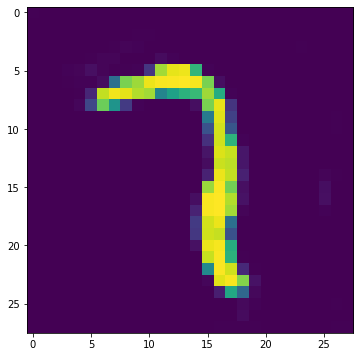

4it [00:00,  9.01it/s]


 EPOCH 8 iter 1880 
 g_loss 5.014774322509766 
 d_loss 0.09373550117015839 



49it [00:02, 26.67it/s]

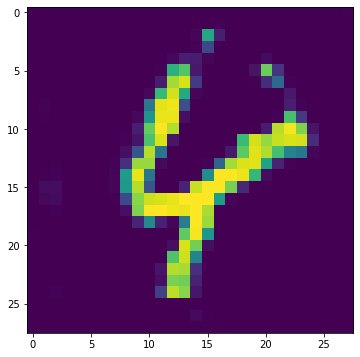

55it [00:02, 21.10it/s]


 EPOCH 8 iter 1930 
 g_loss 5.1121063232421875 
 d_loss 0.5331118106842041 



100it [00:04, 26.37it/s]

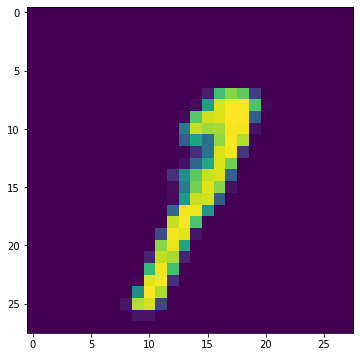

106it [00:04, 20.94it/s]


 EPOCH 8 iter 1980 
 g_loss 4.858314514160156 
 d_loss 0.11893683671951294 



148it [00:06, 26.47it/s]

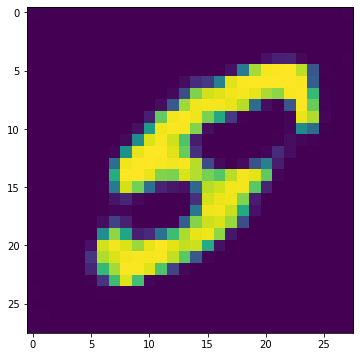

154it [00:06, 18.19it/s]


 EPOCH 8 iter 2030 
 g_loss 6.680417060852051 
 d_loss 0.16322916746139526 



199it [00:08, 25.57it/s]

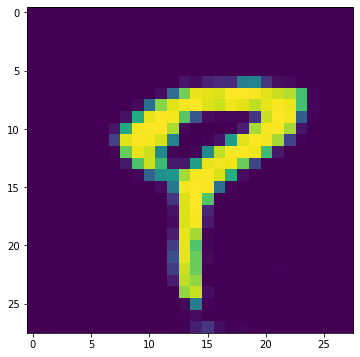

205it [00:08, 20.63it/s]


 EPOCH 8 iter 2080 
 g_loss 4.565451145172119 
 d_loss 0.07119609415531158 



235it [00:10, 23.33it/s]
0it [00:00, ?it/s]

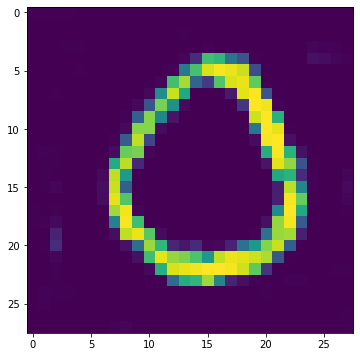

4it [00:00,  9.01it/s]


 EPOCH 9 iter 2115 
 g_loss 7.562549114227295 
 d_loss 0.37419453263282776 



49it [00:02, 26.92it/s]

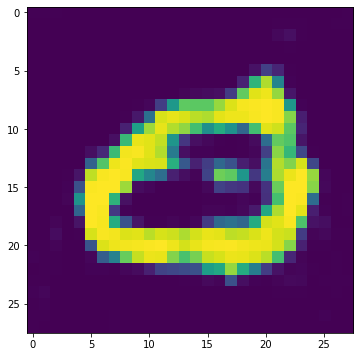

55it [00:02, 20.91it/s]


 EPOCH 9 iter 2165 
 g_loss 4.771231174468994 
 d_loss 0.20625147223472595 



100it [00:04, 25.93it/s]

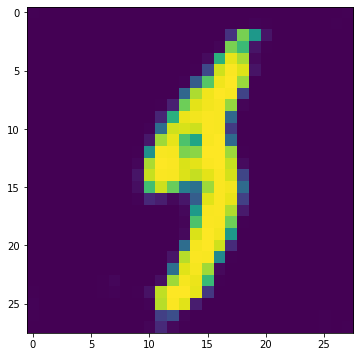

106it [00:04, 20.64it/s]


 EPOCH 9 iter 2215 
 g_loss 5.502551078796387 
 d_loss 0.09466813504695892 



148it [00:06, 26.50it/s]

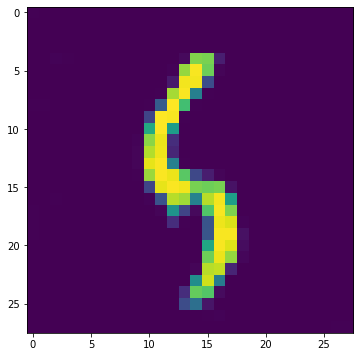

154it [00:06, 20.93it/s]


 EPOCH 9 iter 2265 
 g_loss 4.443859100341797 
 d_loss 0.16689950227737427 



199it [00:08, 26.46it/s]

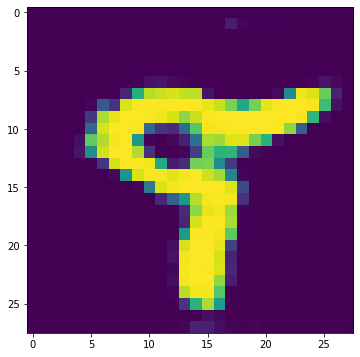

205it [00:08, 21.02it/s]


 EPOCH 9 iter 2315 
 g_loss 6.5760111808776855 
 d_loss 0.10075617581605911 



235it [00:09, 23.60it/s]
100%|██████████| 10/10 [01:47<00:00, 10.78s/it]


In [26]:
figsize(6, 6)

j = 0
for epoch in trange(EPOCHS):
	for i, data in tqdm(enumerate(trainloader)):

		images = data[0].to(DEVICE)

		# train discriminator
		discriminator.zero_grad()

		d_out_real = discriminator(images)
		d_loss_real = bce(d_out_real, torch.ones(d_out_real.shape[0], 1).to(DEVICE))
		d_loss_real.backward()
		d_optim.step()

		discriminator.zero_grad()

		noise1 = get_noise()
		g_out_fake = generator(noise1).detach()
		d_out_fake = discriminator(g_out_fake)
		d_loss_fake = bce(d_out_fake, torch.zeros(d_out_fake.shape[0], 1).to(DEVICE))
		d_loss_fake.backward()
		d_optim.step()

		d_loss_avg = (d_loss_real + d_loss_fake) / 2
		d_losses.append(d_loss_avg.item())
		
		# train generator
		generator.zero_grad()

		noise2 = get_noise()
		g_out1 = generator(noise2)
		d_out1 = discriminator(g_out1)
		t_loss1 = bce(d_out1, torch.ones(d_out1.shape[0], 1).to(DEVICE))

		t_loss1.backward()
		g_optim.step()

		g_losses.append(t_loss1.item())

		if i % 50 == 0:
			imshow(test_render(generator))
			show()
			print(
					'\n',
					'EPOCH', epoch, 'iter', j,
					'\n',
					'g_loss', g_losses[len(g_losses) - 1],
					'\n',
					'd_loss', d_losses[len(d_losses) - 1],
					'\n',
			)

		j += 1

In [18]:
print(g_losses[0])
print(d_losses[1])
print(g_losses[len(g_losses) - 1])
print(d_losses[len(d_losses) - 1])

2.553227424621582
2.650153636932373
5.37606143951416
0.13779285550117493


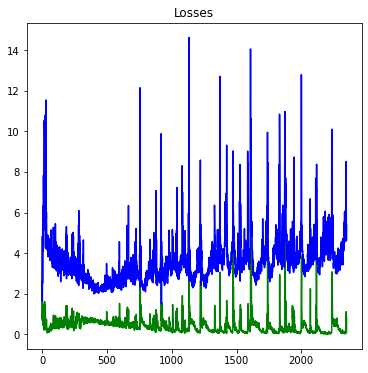

In [19]:
plt.plot(range(len(d_losses)), d_losses, 'g', label='Discriminator Loss')
plt.plot(range(len(g_losses)), g_losses, 'b', label='Generator Loss')
plt.title('Losses')
plt.show()

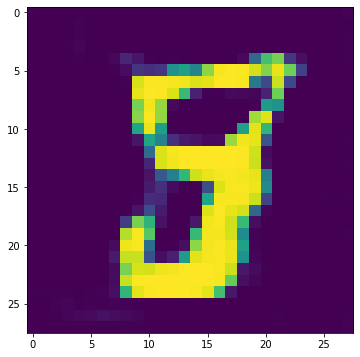

In [20]:
# n1 = torch.randn(BATCH, 1, ns1, ns2).to(DEVICE)
n1 = get_noise()
out = generator(n1)
imshow(out[0].reshape(28, 28).cpu().detach())

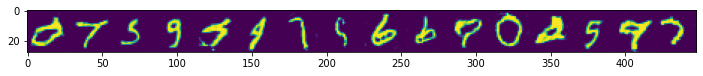

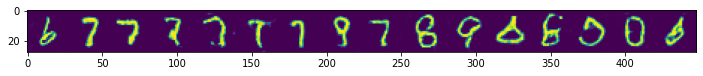

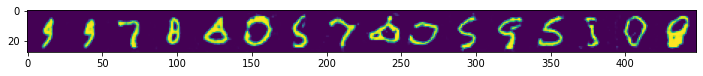

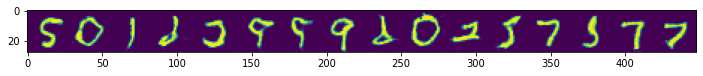

In [27]:
for _ in range(4):
  images = torch.tensor([])
  for i in range(16):
    n1 = get_noise()
    out = generator(n1)
    gen = out[0].reshape(28, 28).cpu().detach()
    images = torch.cat((images, gen.T))
  
  figsize(12,12)
  imshow(images.T)
  show()

In [38]:
n_s = get_noise()

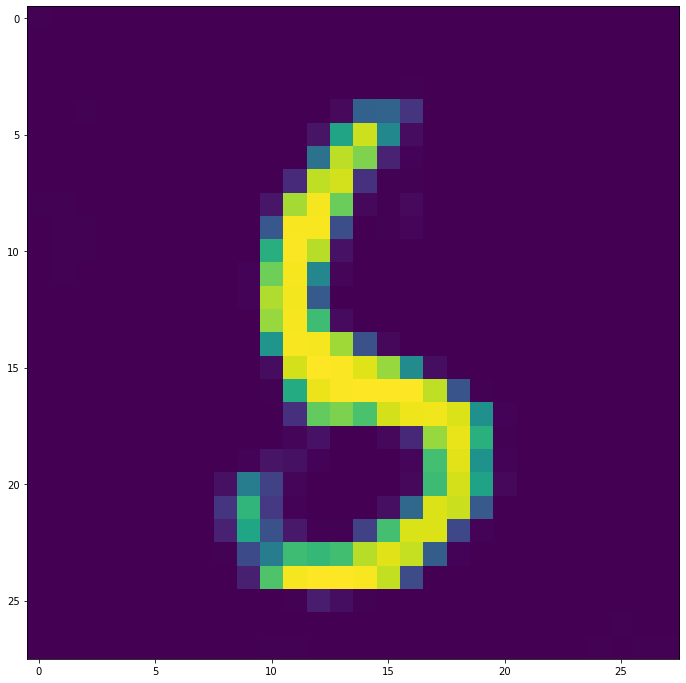

In [39]:
out = generator(n_s)

img = out[0].reshape(28, 28).cpu().detach()

imshow(img)